## General Mixture Models

author: Jacob Schreiber <br>
contact: jmschreiber91@gmail.com

It is frequently the case that the data you have is not explained by a single underlying distribution. Typically this is because there are multiple phenomena occurring in the data set, each with their own underlying distribution. If we want to try to recover the underlying distributions, we need to have a model which has multiple components. An example could be sensor readings where the majority of the time a sensor shows no signal, but sometimes it detects some phenomena. Modeling both phenomena as a single distribution would be silly because the readings would come from two distinct phenomena.

A solution to the problem of having more than one single underlying distribution is to use a mixture of distributions instead of a single distribution, commonly called a mixture model. This type of compositional model builds a more complex probability distribution from a set of simpler ones. A common type, called a Gaussian Mixture Model, is composed of Gaussian distributions, but mathematically there is no need for these distributions to all be Gaussian. In fact, there is no need for these distributions to be simple probability distributions.

In this tutorial we'll explore how to do mixture modeling in pomegranate, compare against scikit-learn's implementation of Gaussian mixture models, and explore more complex types of mixture modeling that one can do with probabilistic modeling.

In [1]:
%pylab inline
import seaborn; seaborn.set_style('whitegrid')

import torch

from pomegranate.gmm import GeneralMixtureModel
from pomegranate.distributions import *


numpy.random.seed(0)
numpy.set_printoptions(suppress=True)

%load_ext watermark
%watermark -m -n -p numpy,scipy,torch,pomegranate

Populating the interactive namespace from numpy and matplotlib
numpy      : 1.23.4
scipy      : 1.9.3
torch      : 1.13.0
pomegranate: 1.0.0

Compiler    : GCC 11.2.0
OS          : Linux
Release     : 4.15.0-208-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit



### A simple example: Gaussian mixture models

Let's start off with a simple example. Perhaps we have a data set like the one below, which is made up of not a single blob, but many blobs. It doesn't seem like any of the simple distributions that pomegranate has implemented can fully capture what's going on in the data.

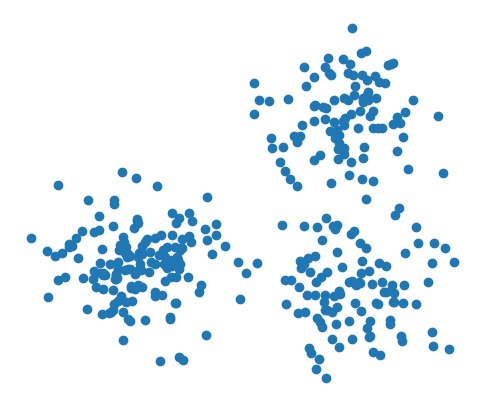

In [2]:
numpy.random.seed(0)

X = numpy.concatenate([numpy.random.normal((7, 2), 1, size=(100, 2)),
                       numpy.random.normal((2, 3), 1, size=(150, 2)),
                       numpy.random.normal((7, 7), 1, size=(100, 2))]).astype('float32')

plt.figure(figsize=(6, 5))
plt.scatter(X[:,0], X[:,1])
plt.axis(False)
plt.show()

It seems clear to us that this data is composed of three blobs. Accordingly, rather than trying to find some complex single distribution that can describe this data, we can describe it as a mixture of three Gaussian distributions. In the same way that we could initialize a basic distribution using the `fit` method, we can initialize a mixture model using it, additionally passing in the type(s) of distribution(s) to use and the number of components.

In [3]:
model = GeneralMixtureModel([Normal(), Normal(), Normal()], verbose=True).fit(X)

[1] Improvement: 0.216064453125, Time: 0.001145s
[2] Improvement: 0.0286865234375, Time: 0.0008411s


Now we can look at the probability densities if we had used a single Gaussian distribution versus using this mixture of three Gaussian models.

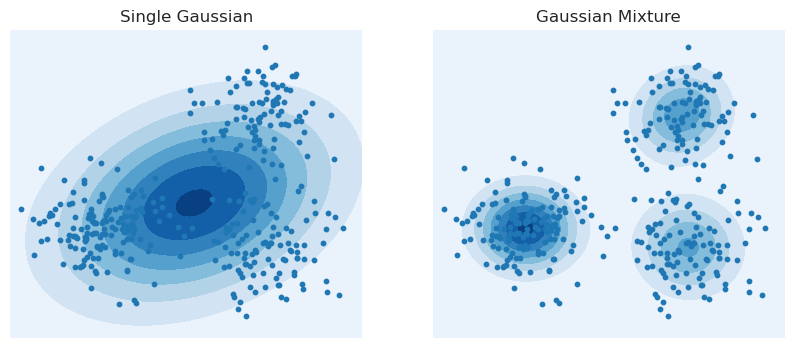

In [4]:
x = numpy.arange(-1, 10.1, .1)
y = numpy.arange(-1, 10.1, .1)

xx, yy = numpy.meshgrid(x, y)
x_ = numpy.array(list(zip(xx.flatten(), yy.flatten())))

p1 = Normal().fit(X).probability(x_).reshape(len(x), len(y))
p2 = model.probability(x_).reshape(len(x), len(y))


plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Single Gaussian", fontsize=12)
plt.contourf(xx, yy, p1, cmap='Blues')
plt.scatter(X[:,0], X[:,1], s=10)
plt.axis(False)

plt.subplot(122)
plt.title("Gaussian Mixture", fontsize=12)
plt.contourf(xx, yy, p2, cmap='Blues')
plt.scatter(X[:,0], X[:,1], s=10)
plt.axis(False)
plt.show()

It looks like, unsurprisingly, the mixture model is able to better capture the structure of the data. The single Gaussian is so bad that the region of highest density (the darkest blue ellipse) has very few real points in it. In contrast, the darkest regions in the mixture densities correspond to where there are the most points in the clusters.

### Initialization and Fitting

Initialization of mixture models is similar to that of probability distributions: you can either pass in initialized values, or not. If you already have probability distributions, and optionally already have prior values on which distribution generated the data, you can pass those into initialization and use the model directly.

In [5]:
d1 = Exponential([1.3, 3.3])
d2 = Exponential([2.2, 0.4])

model = GeneralMixtureModel([d1, d2], priors=[0.2, 0.8])

Alternatively, if you don't know the values, you can pass in uninitialized distributions and then fit it.

In [6]:
d1 = Exponential()
d2 = Exponential()

X2 = torch.abs(torch.randn(15, 3))

model = GeneralMixtureModel([d1, d2], verbose=True).fit(X2)

[1] Improvement: 0.8422355651855469, Time: 0.0007176s
[2] Improvement: 0.23958969116210938, Time: 0.0005503s
[3] Improvement: 0.11565399169921875, Time: 0.0005138s
[4] Improvement: 0.07136917114257812, Time: 0.0004883s


You can inspect the learned prior probabilities.

In [7]:
model.priors

Parameter containing:
tensor([0.8565, 0.1435])

After training, you can inspect the distribution objects.

In [8]:
d1.scales, d2.scales

(Parameter containing:
 tensor([0.9047, 0.9780, 0.7445]),
 Parameter containing:
 tensor([0.7281, 0.3527, 0.9284]))

### Probability and Log Probability

Because mixture models themselves are technically probability distributions, it should be unsurprising that the calculation of probabilities and log probabilities are identical to that of probability distributions.

In [9]:
model.log_probability(X2)

tensor([-1.9188, -3.7001, -2.8847, -3.1817, -1.6772, -1.8678, -3.8099, -2.6887,
        -3.4597, -2.5457, -1.5600, -0.9176, -1.4670, -2.0735, -3.8544])

In [10]:
d1.log_probability(X2), d2.log_probability(X2)

(tensor([-1.8586, -3.6041, -2.8660, -3.0401, -1.5696, -1.8315, -3.6627, -2.6193,
         -3.3195, -2.6105, -1.8031, -1.0723, -1.7300, -2.1385, -3.7464]),
 tensor([-2.3815, -4.6215, -3.0040, -5.5725, -2.8109, -2.1167, -6.7331, -3.2486,
         -5.7406, -2.2277, -0.7321, -0.2995, -0.5996, -1.7543, -4.9963]))

In [11]:
model.probability(X2)

tensor([0.1468, 0.0247, 0.0559, 0.0415, 0.1869, 0.1545, 0.0222, 0.0680, 0.0314,
        0.0784, 0.2101, 0.3995, 0.2306, 0.1257, 0.0212])

In [12]:
d1.probability(X2), d2.probability(X2)

(tensor([0.1559, 0.0272, 0.0569, 0.0478, 0.2081, 0.1602, 0.0257, 0.0729, 0.0362,
         0.0735, 0.1648, 0.3422, 0.1773, 0.1178, 0.0236]),
 tensor([0.0924, 0.0098, 0.0496, 0.0038, 0.0602, 0.1204, 0.0012, 0.0388, 0.0032,
         0.1078, 0.4809, 0.7412, 0.5490, 0.1730, 0.0068]))

### Prediction

A key utility of mixture models, as a clustering method, is that they can make predictions for which component better fits each data point. These methods mirror those of scikit-learn. Starting off, if you just want predictions of cluster label for each point you can use the `predict` method. Let's return to the Gaussian mixture model for an example.

In [13]:
model = GeneralMixtureModel([Normal(), Normal(), Normal()], verbose=True).fit(X)
model.predict(X)

[1] Improvement: 0.216064453125, Time: 0.0007911s
[2] Improvement: 0.0286865234375, Time: 0.001209s


tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2,

If you're interested in the underlying probabilities, which are the likelihoods under the probability distributions multiplied by the priors and then normalized (sometimes called the responsibility matrix), you can use `predict_proba` to get these probabilities.

In [14]:
model.predict_proba(X)[::15]

tensor([[3.2331e-10, 1.0000e+00, 5.0365e-06],
        [1.3677e-06, 9.9998e-01, 2.1502e-05],
        [5.2814e-05, 9.9995e-01, 1.1250e-06],
        [3.7857e-05, 9.9834e-01, 1.6255e-03],
        [1.1822e-07, 1.0000e+00, 1.1827e-08],
        [8.1322e-06, 9.8747e-01, 1.2524e-02],
        [3.6977e-06, 1.0000e+00, 5.8392e-09],
        [9.9969e-01, 3.0660e-04, 1.0668e-06],
        [1.0000e+00, 2.7696e-07, 2.4643e-11],
        [9.9968e-01, 3.2161e-04, 1.4796e-12],
        [1.0000e+00, 6.9959e-09, 8.9382e-10],
        [9.9966e-01, 3.3986e-04, 1.9472e-09],
        [9.9987e-01, 1.2673e-04, 1.1254e-07],
        [9.9992e-01, 7.5676e-05, 2.5076e-08],
        [9.9969e-01, 3.0740e-04, 3.1747e-06],
        [1.0000e+00, 2.4480e-08, 1.8340e-10],
        [9.9986e-01, 1.2941e-04, 7.4965e-06],
        [4.5694e-15, 3.9609e-07, 1.0000e+00],
        [2.0310e-08, 1.0201e-02, 9.8980e-01],
        [9.1368e-08, 1.3950e-01, 8.6050e-01],
        [9.5965e-08, 1.5413e-05, 9.9998e-01],
        [1.2553e-08, 1.0525e-04, 9

If you'd like to go even deeper, you can get log probabilities -- which are the space where all the calculations are done for numeric stability -- using the `predict_log_proba` method.

In [15]:
model.predict_log_proba(X)[::15]

tensor([[-2.1852e+01, -4.7684e-06, -1.2199e+01],
        [-1.3502e+01, -2.2650e-05, -1.0747e+01],
        [-9.8487e+00, -5.3883e-05, -1.3698e+01],
        [-1.0182e+01, -1.6646e-03, -6.4219e+00],
        [-1.5951e+01,  0.0000e+00, -1.8253e+01],
        [-1.1720e+01, -1.2612e-02, -4.3801e+00],
        [-1.2508e+01, -3.8147e-06, -1.8959e+01],
        [-3.0780e-04, -8.0900e+00, -1.3751e+01],
        [-2.3842e-07, -1.5099e+01, -2.4427e+01],
        [-3.2187e-04, -8.0422e+00, -2.7239e+01],
        [ 0.0000e+00, -1.8778e+01, -2.0836e+01],
        [-3.3998e-04, -7.9870e+00, -2.0057e+01],
        [-1.2684e-04, -8.9735e+00, -1.6000e+01],
        [-7.5579e-05, -9.4890e+00, -1.7501e+01],
        [-3.1066e-04, -8.0874e+00, -1.2660e+01],
        [ 0.0000e+00, -1.7525e+01, -2.2419e+01],
        [-1.3685e-04, -8.9525e+00, -1.1801e+01],
        [-3.3019e+01, -1.4742e+01, -4.7684e-07],
        [-1.7712e+01, -4.5853e+00, -1.0253e-02],
        [-1.6208e+01, -1.9697e+00, -1.5024e-01],
        [-1.6159e+01

### Zero-inflated Mixtures

A common way to view zero-inflated distributions is as a mixture where one component is a dirac delta distribution with a probability mass entirely on zero and whatever the other distribution is. The zero-inflation is explicitly modeled because sometimes your data will have zeroes that do not come from the primary thing being modeled. Although zero-inflated distributions are explicitly implemented already, one could manually implement one like this:

In [16]:
p = numpy.array([30, 1, 3, 7, 8, 7, 4, 3, 2, 1, 2, 1, 1, 1])
X = numpy.random.choice(len(p), size=(500, 1), p=p/p.sum())

In [17]:
d = Poisson().fit(X)
d.lambdas

Parameter containing:
tensor([3.3220])

In [18]:
model = GeneralMixtureModel([DiracDelta([1]), Poisson([1])], verbose=True).fit(X)
model.distributions[1].lambdas

[1] Improvement: 1369.84814453125, Time: 0.0006914s
[2] Improvement: 89.228271484375, Time: 0.0006466s
[3] Improvement: 0.164306640625, Time: 0.000586s
[4] Improvement: 0.0001220703125, Time: 0.0006366s


Parameter containing:
tensor([5])

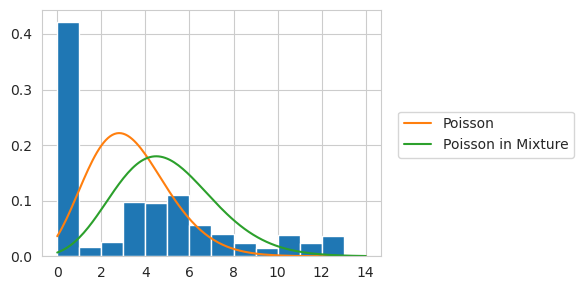

In [19]:
x = numpy.arange(0, len(p)+0.1, 0.1)
y1 = d.probability(x.reshape(-1, 1))
y2 = model.distributions[1].probability(x.reshape(-1, 1))


plt.figure(figsize=(6, 3))
plt.hist(X[:,0], density=True, bins=numpy.arange(0, len(p), 1))
plt.plot(x, y1, label="Poisson")
plt.plot(x, y2, label="Poisson in Mixture")
plt.legend(loc=(1.05, 0.4))
plt.tight_layout()

Alternatively, we can use the ZeroInflated wrapper to do this.

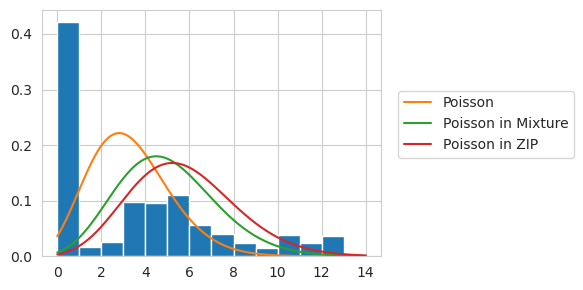

In [20]:
d0 = Poisson()
d = ZeroInflated(d0).fit(X)

y3 = d0.probability(x.reshape(-1, 1))

plt.figure(figsize=(6, 3))
plt.hist(X[:,0], density=True, bins=numpy.arange(0, len(p), 1))
plt.plot(x, y1, label="Poisson")
plt.plot(x, y2, label="Poisson in Mixture")
plt.plot(x, y3, label="Poisson in ZIP")
plt.legend(loc=(1.05, 0.4))
plt.tight_layout()

The ZeroInflated wrappers extends to multivariate distributions in a way that the mixture model implementation doesn't. Simply, using a DiracDelta by itself will give a zero probability to all examples that have one or more non-zero values. Because we want each feature to be scored independently, in that all zeroes in the matrix have some probability of belonging to the DiracDelta component, we need to modify the internals slightly. Here is the result of using that.

In [21]:
p = numpy.array([30, 1, 3, 7, 8, 7, 4, 3, 2, 1, 2, 1, 1, 1])
X = numpy.random.choice(len(p), size=(500, 3), p=p/p.sum())

d = Poisson().fit(X)

model = GeneralMixtureModel([DiracDelta([1, 1, 1]), Poisson([1.0, 1.0, 1.0])]).fit(X)
model.distributions[1].lambdas

ZIP = ZeroInflated(Poisson()).fit(X)

d.lambdas, model.distributions[1].lambdas, ZIP.distribution.lambdas

(Parameter containing:
 tensor([3.3160, 3.1280, 3.1860]),
 Parameter containing:
 tensor([3.6519, 3.4448, 3.5087]),
 Parameter containing:
 tensor([5.7558, 5.3920, 5.3447]))